In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import scipy.stats as stats
import joblib
from pathlib import Path

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
while not (PROJECT_ROOT / ".git").exists() and not (PROJECT_ROOT / "pyproject.toml").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

In [67]:
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_PATH = DATA_DIR / "raw" / "train_titanic.csv"
PROCESSED_DATA_PATH = DATA_DIR / "processed" / "titanic_processed.csv"
ARTIFACTS_PATH = PROJECT_ROOT / "artifacts"

In [4]:
df=pd.read_csv(RAW_DATA_PATH, index_col='PassengerId')

In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
# some changes in the data types
df['Pclass'] = df['Pclass'].astype('category')
df['SibSp'] = df['SibSp'].astype('category')
df['Parch'] = df['Parch'].astype('category')

In [9]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

here it can be seen that there are 3 columns, which 1 is numerical and 2 are categorical. there is only 2 missing in the "Embarked" thus it may be optimal to just drop the missing rows or impute with the most_frequent considering the group(f.e. "Sex" or "Pclass". some experiments are needed). 


What about the "Age": for sake of time the easiest way would be to impute the mean


In the "Cabin" there almost 2/3 of all rows has missing value. there are 2 ways either drop this column or consider the null values as another categ value(which can give some more info)

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

Analyzing nd charting the numerical columns to see the distribution

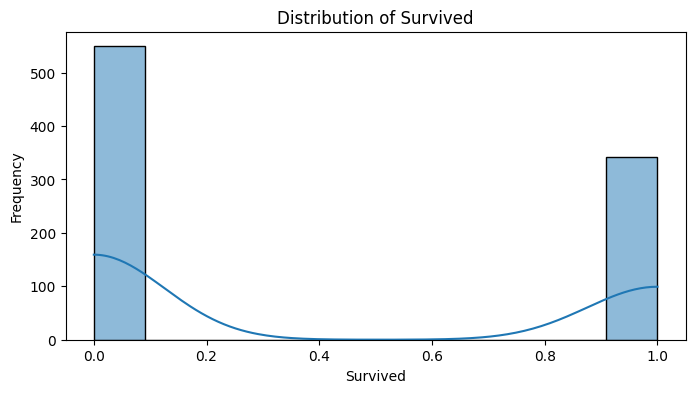

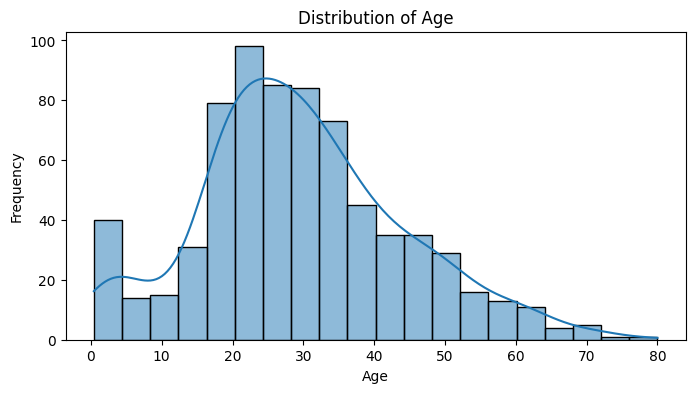

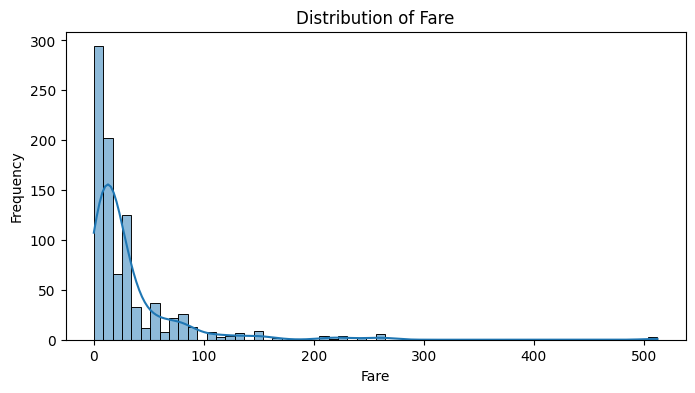

In [11]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Here we only have 2 num columns: "Age", "Fare"
and in the column "Age" we can see that it almost follows the normal distribution(will be checked with the stats), hence maybe filling the null values with the mean will be better idea here

what about the "Fare", it has a long right tail, np.log can be used

In [12]:
df[cat_cols].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [13]:
for col in cat_cols:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("\n")

Value counts for Name:
Name
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
Allen, Mr. William Henry                               1
                                                      ..
Montvila, Rev. Juozas                                  1
Graham, Miss. Margaret Edith                           1
Johnston, Miss. Catherine Helen "Carrie"               1
Behr, Mr. Karl Howell                                  1
Dooley, Mr. Patrick                                    1
Name: count, Length: 891, dtype: int64


Value counts for Sex:
Sex
male      577
female    314
Name: count, dtype: int64


Value counts for Ticket:
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
PC 17590            1
17463               1
330877        

column "Name", we can get another column by taking only the title such Mr., Miss. and etc. and the len of the text(i do not think that it is gonna give some more info, but still i am gonna test it with the baseline by the weight it gives to this column)

column "Ticket", i am not really sure what these number realle represent but still i am gonna try to create new feat such only num or num+text(again will check the importance with baseline)

column "Cabin", this column can be seperated to 2 new feat: 1 with the first letter(seems to be like row number) and second one the number(leaving the number as it is unlikely to give some more info so new ideas are needed maybe turn 2 decimal number to new column such 2_num, if it is 1 number to 1_num, and etc.)

Right now i am gonna start little faeture engeenering 

In [14]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['length_Name'] = df['Name'].apply(len)

In [15]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

We can see a lot of titles with only 1 occurence. the model most likely to not able to predict based on these low occurence but still instead of removing i am gonna see what i can do later, maybe cluster these low occurences to one common class

what about the length, we will see the importance through the baseline

In [16]:
#wanted to see if there are common prefixes in the 'Ticket' column
df['Ticket'].apply(lambda x: x.split(' ')[0] if not x.split(' ')[0].isdigit() else 'No_Prefix').value_counts()

Ticket
No_Prefix     661
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
SOTON/O.Q.      8
CA.             8
A/5.            7
SOTON/OQ        7
CA              6
STON/O2.        6
F.C.C.          5
SC/PARIS        5
C               5
S.O.C.          5
SC/Paris        4
LINE            4
PP              3
A/4.            3
A/4             3
S.O./P.P.       3
SC/AH           3
A./5.           2
P/PP            2
A.5.            2
WE/P            2
SOTON/O2        2
S.C./PARIS      2
S.C./A.4.       1
Fa              1
S.O.P.          1
SO/C            1
S.P.            1
W.E.P.          1
A4.             1
A/S             1
SC              1
SW/PP           1
SCO/W           1
W/C             1
S.W./PP         1
F.C.            1
C.A./SOTON      1
Name: count, dtype: int64

In [17]:
df['Ticket_is_digit'] = df['Ticket'].apply(lambda x: 1 if x.isdigit() else 0)

In [18]:
df['Ticket_is_digit']= df['Ticket_is_digit'].astype('category')

In [19]:
df["FamilySize"] = df["SibSp"].astype(int) + df["Parch"].astype(int) + 1

In [20]:
df['FamilySize']= df['FamilySize'].astype('category')

In [21]:
df['Cabin'].value_counts()

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

In [22]:
#i am gonna treat missing cabins as a separate category
df["Cabin_symbol"] = df['Cabin'].apply(lambda x: "missing" if pd.isna(x) else x[0])


In [23]:
num_data_cabin=df['Cabin'].apply(lambda x: "missing" if pd.isna(x) 
                  else x.split(" ")[0][1:] if not x[1:].isnumeric() 
                  else x[1:])

Here we can see that numeric data of cabin has a low common occurence hence i tried to create new categ column with 3 values

In [24]:
df['Cabin_digit'] = num_data_cabin.apply(lambda  x: "1_digit" if x=='' else x if x=="missing" else str(len(str(int(x))))+'_digit')

Removing unnecessary columns

In [25]:
df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], inplace=True)

In [26]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,length_Name,Ticket_is_digit,FamilySize,Cabin_symbol,Cabin_digit
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,7.2500,S,Mr,23,0,2,missing,missing
2,1,1,female,38.0,71.2833,C,Mrs,51,0,2,C,2_digit
3,1,3,female,26.0,7.9250,S,Miss,22,0,1,missing,missing
4,1,1,female,35.0,53.1000,S,Mrs,44,1,2,C,3_digit
5,0,3,male,35.0,8.0500,S,Mr,24,1,1,missing,missing


In [27]:
df.reset_index(inplace=True)

In [28]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [29]:
num_cols

Index(['PassengerId', 'Survived', 'Age', 'Fare', 'length_Name'], dtype='object')

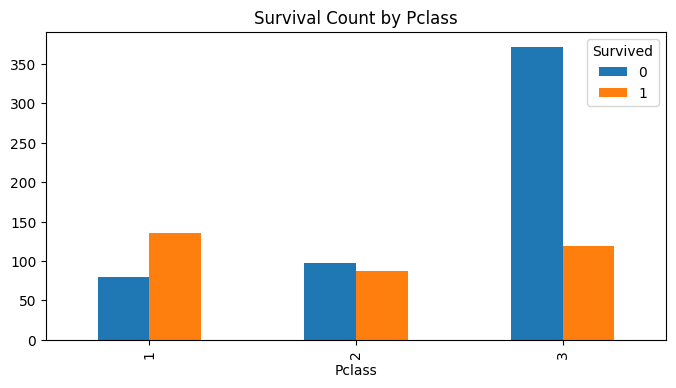

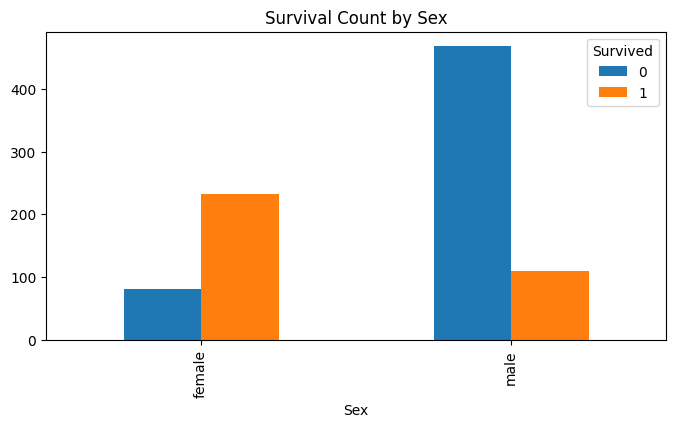

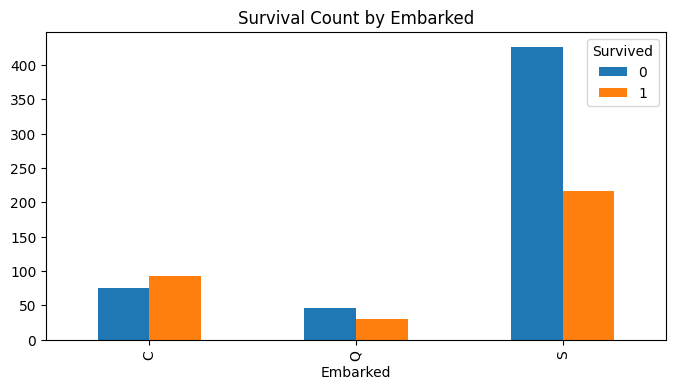

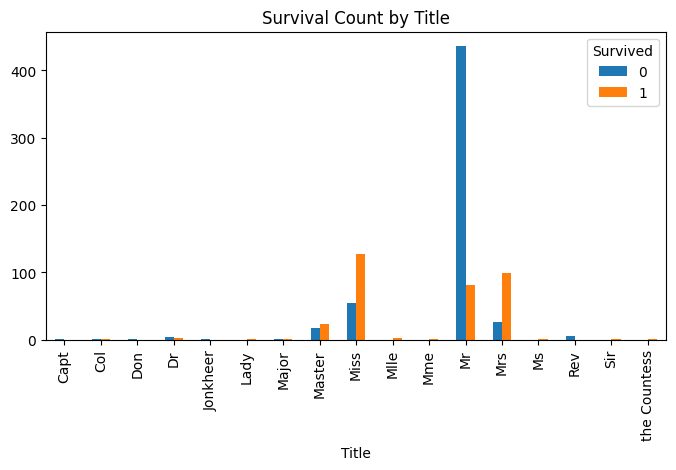

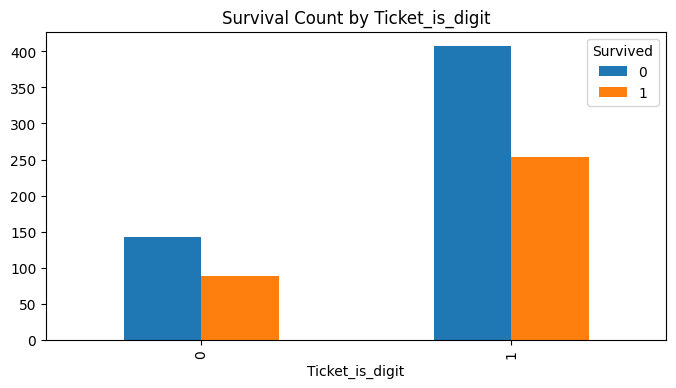

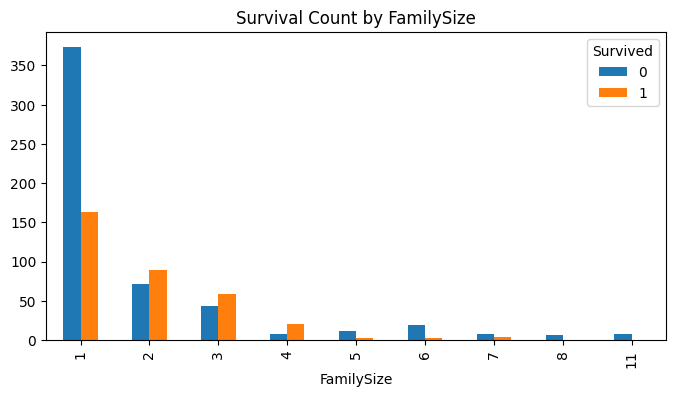

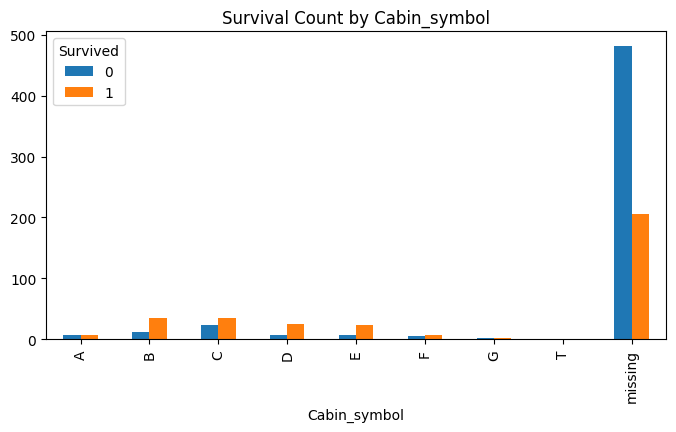

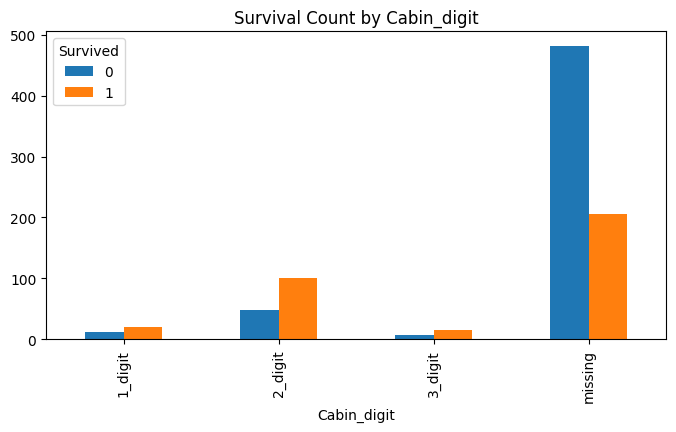

In [30]:
for col in cat_cols:
    pd.pivot_table(df, index=col, 
                   aggfunc='count', 
                   columns='Survived', 
                   values='PassengerId', observed=True).plot(kind='bar', figsize=(8, 4))
    plt.title(f'Survival Count by {col}')

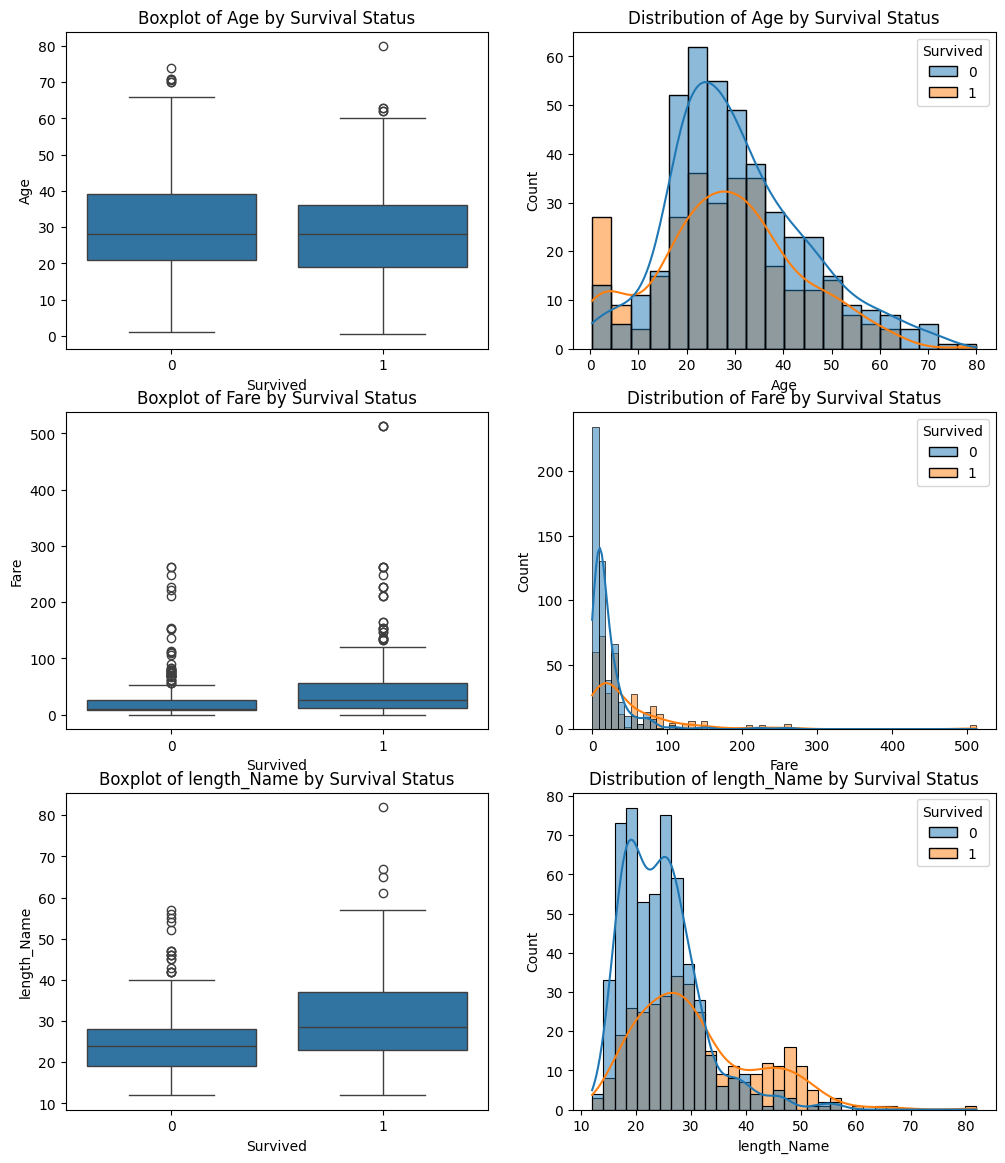

In [31]:
fig, axes =plt.subplots(figsize=(12, 14), ncols=2, nrows=3)
for i, col in enumerate(num_cols.drop(['PassengerId', 'Survived'])):
    sns.boxplot(x='Survived', y=col, data=df, ax=axes[i , 0])
    axes[i, 0].set_title(f'Boxplot of {col} by Survival Status')
    axes[i, 0].set_xlabel('Survived')
    axes[i, 0].set_ylabel(col)
    sns.histplot(data=df, x=col, hue='Survived', kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {col} by Survival Status')
    axes[i, 1].set_xlabel(col)

In [32]:
cat_cols

Index(['Pclass', 'Sex', 'Embarked', 'Title', 'Ticket_is_digit', 'FamilySize',
       'Cabin_symbol', 'Cabin_digit'],
      dtype='object')

now i am gonna start the analysing the p value to see if the distribution for particular column differ between target classes

for p value threshold we gonna take 0.05

our hypothesis are:

    Null hypo(H0): no difference(distribution is the same for target 0 and 1) or we do not have enough info to reject H0 
    Alternative hypo(H1): there is a difference(distribution differs between groups)

    if the p value is less than 0.05 we reject the H0, but if it is otherwise we fail to reject the H0(do not have enough evidence)

when the p value can be treated as trustworthy:

    for it we need to look at other parameters such as expected. the threshold for expected is assumed to be >=5. but if it is less then the p value in not trustworthy.

In [33]:
def wilson_ci(k, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = stats.norm.ppf(1 - alpha/2)   # 1.96 for 95%
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom
    return (center - half, center + half)

def cat_vs_target(col, target="Survived", df=df, alpha=0.05, show_ci=True):

    tab = pd.crosstab(df[col], df[target])

    # survival rate per category (proportion of 1s)
    rate = df.groupby(col)[target].mean().sort_values(ascending=False)

    print(f"\n=== {col} ===")
    print("Survival rate:\n", rate)
    print("\nCrosstab:\n", tab)

    # --- CI table for survival rate per category
    if show_ci:
        rows = []
        for cat in tab.index:
            n = int(tab.loc[cat].sum())
            k = int(tab.loc[cat, 1]) if 1 in tab.columns else 0
            r = k / n if n else np.nan
            lo, hi = wilson_ci(k, n, alpha=alpha)
            rows.append((cat, n, k, r, lo, hi))

        ci_df = pd.DataFrame(
            rows,
            columns=[col, "n", "survived_k", "survival_rate", f"ci{int((1-alpha)*100)}_lo", f"ci{int((1-alpha)*100)}_hi"]
        ).sort_values("survival_rate", ascending=False)

        print(f"\nSurvival rate + {int((1-alpha)*100)}% CI (Wilson):")
        print(ci_df.to_string(index=False))

    # --- Chi-square (general)
    chi2, p_chi, dof, expected = stats.chi2_contingency(tab)

    # Use Fisher if 2x2 and expected counts are small
    if tab.shape == (2, 2) and expected.min() < 5:
        oddsratio, p = stats.fisher_exact(tab.values)
        print(f"\nFisher exact p-value: {p:.6f} | odds_ratio={oddsratio:.3f}")
    else:
        print(f"\nChi-square p-value: {p_chi:.6f} | dof={dof}")

    print(f"Expected values:\n{expected}")
    print("======" * 10)

In [34]:
for col in cat_cols:
    cat_vs_target(col)


=== Pclass ===
Survival rate:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Crosstab:
 Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Survival rate + 95% CI (Wilson):
 Pclass   n  survived_k  survival_rate  ci95_lo  ci95_hi
      1 216         136       0.629630 0.563490 0.691239
      2 184          87       0.472826 0.401983 0.544781
      3 491         119       0.242363 0.206554 0.282171

Chi-square p-value: 0.000000 | dof=2
Expected values:
[[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]

=== Sex ===
Survival rate:
 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Crosstab:
 Survived    0    1
Sex               
female     81  233
male      468  109

Survival rate + 95% CI (Wilson):
   Sex   n  survived_k  survival_rate  ci95_lo  ci95_hi
female 314         233       0.742038 0.690925 0.787301
  male 577         109       0.188908 0.

C:\Users\User\AppData\Local\Temp\ipykernel_9864\1215855341.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(col)[target].mean().sort_values(ascending=False)
C:\Users\User\AppData\Local\Temp\ipykernel_9864\1215855341.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(col)[target].mean().sort_values(ascending=False)
C:\Users\User\AppData\Local\Temp\ipykernel_9864\1215855341.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

What can be understood from these:


Note: here i also added the CI(confidential intervals) for survival rate for each category. what it looks for is

“If we could repeatedly sample similar Titanic passengers, in 95% of those samples the interval would contain the true survival rate for this group.” 
Now it is not really important but still useful to know
1) there is a clear difference in distrubtion of features such (Sex, Embarked, Cabin_symbol(for now we can not simplify it that is why we consider it as it is), Cabin_digit)
2) there is no difference in distribution in features such (Ticket_is_digit), for now i am not gonna remove to see the importance the basemodel give to it
3) the table shows that there is a clear diff in the features such (Title, FamilySize), but this data can not be considered as trustworthy because of the expected value it returns(which is less than 5 partially or fully). we can not immediately conclude that these features do not differ, that is why we need to deal with the inital problem occuring for less expected value, which is a lot of classes with low occurence which is true in our case(it can be seen with crosstab). Special case happens in the feature Cabin_symbol, where are some values in expected less than 5, but in that case we can not do any other reforming or simplyfying. Approaches for dealing with the feature such (Title, FamilySize) we can either put each class with low occurence to new class such "Rare", which will be done for Title with a lot of titles that occur less, or group the classes into another one(f.e. 1->alone, 1-4->midsize_family, 4+->large_family), which will be done for FamilySize, and then again testes them 

In [35]:
df['FamilySize_cluster'] = pd.cut(df['FamilySize'], bins=[0, 1, 4, np.inf], labels=['Alone', 'MidSizeFamily', 'LargeFamily'])

In [36]:
vc=df['Title'].value_counts()
rare_titles = vc[vc<10].index
df['Title_transformed'] = df['Title'].replace(rare_titles, 'Rare', inplace=False)

For now i am saving the rare_titles because we may need it when testing out model for out test dataset

In [37]:
pd.pivot_table(df, index='Title_transformed', 
                   aggfunc='count', columns='Survived', 
                   values='PassengerId', observed=True)

Survived,0,1
Title_transformed,,
Master,17,23
Miss,55,127
Mr,436,81
Mrs,26,99
Rare,15,12


In [38]:
cat_vs_target('Title_transformed')
cat_vs_target('FamilySize_cluster')


=== Title_transformed ===
Survival rate:
 Title_transformed
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.444444
Mr        0.156673
Name: Survived, dtype: float64

Crosstab:
 Survived             0    1
Title_transformed          
Master              17   23
Miss                55  127
Mr                 436   81
Mrs                 26   99
Rare                15   12

Survival rate + 95% CI (Wilson):
Title_transformed   n  survived_k  survival_rate  ci95_lo  ci95_hi
              Mrs 125          99       0.792000 0.712672 0.853916
             Miss 182         127       0.697802 0.627565 0.759862
           Master  40          23       0.575000 0.421951 0.714906
             Rare  27          12       0.444444 0.275859 0.626870
               Mr 517          81       0.156673 0.127886 0.190525

Chi-square p-value: 0.000000 | dof=4
Expected values:
[[ 24.64646465  15.35353535]
 [112.14141414  69.85858586]
 [318.55555556 198.44444444]
 [ 77.02020202  47.97979798

C:\Users\User\AppData\Local\Temp\ipykernel_9864\1215855341.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(col)[target].mean().sort_values(ascending=False)


here we see that these features: FamilySize, Title_transformed have the p value less that 0.05 and also the expected value fully is big enough

Now see the result of SS(statistical significance) for num->target

Mann–Whitney tests whether the distributions differ between the two groups, not assuming normality->is needed when the data is skewed or has outliers 

Welch t-test checks whether the means differ between groups, allowing different variances->data is almost normalish, mislead if the data has big outliers 

Cohen's d is optional but sometimes is needed make important decisions. it tells how big the difference:
    d= 0.2->small, 0.5->medium, 0.8->large 

Null Hypo(H0)-> the distribution of feature does not differ for target class
Alternative Hypo(H1)-> it differs

if p less than 0.05, we reject the H0, otherwise accept.



In [39]:
def num_vs_target(
    col,
    target="Survived",
    show_effect=True,
    bins=50,
    plot=True,
    ci=True,
    n_boot=5000,
    alpha=0.05,
    seed=42
):
    sub = df[[col, target]].dropna()
    a = sub.loc[sub[target] == 0, col].astype(float).to_numpy()
    b = sub.loc[sub[target] == 1, col].astype(float).to_numpy()

    print(f"\n=== {col} ===")
    print(f"n(y=0)={len(a)} | n(y=1)={len(b)}")

    def desc(x):
        return {
            "mean": float(np.mean(x)),
            "median": float(np.median(x)),
            "std": float(np.std(x, ddof=1)),
            "min": float(np.min(x)),
            "q25": float(np.quantile(x, 0.25)),
            "q75": float(np.quantile(x, 0.75)),
            "max": float(np.max(x)),
        }

    da, db = desc(a), desc(b)
    print("y=0 stats:\n", {k: round(v, 4) for k, v in da.items()})
    print("y=1 stats:\n", {k: round(v, 4) for k, v in db.items()})

    # Tests
    u_stat, p_u = stats.mannwhitneyu(a, b, alternative="two-sided")
    print(f"Mann–Whitney U: U={u_stat:.1f} | p-value={p_u:.6f}")

    t_stat, p_t = stats.ttest_ind(a, b, equal_var=False)  # Welch
    print(f"Welch t-test: t={t_stat:.3f} | p-value={p_t:.6f}")

    # Effect size (Cohen's d)
    d = None
    if show_effect:
        n1, n2 = len(a), len(b)
        s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
        s_pooled = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
        d = (np.mean(b) - np.mean(a)) / (s_pooled + 1e-12)
        print(f"Cohen's d (y=1 minus y=0): {d:.3f}")

    # --- Bootstrap CI function
    def bootstrap_ci(stat_func, a, b, n_boot, alpha, seed):
        rng = np.random.default_rng(seed)
        stats_arr = np.empty(n_boot, dtype=float)

        for i in range(n_boot):
            a_s = rng.choice(a, size=len(a), replace=True)
            b_s = rng.choice(b, size=len(b), replace=True)
            stats_arr[i] = stat_func(a_s, b_s)

        lo = float(np.quantile(stats_arr, alpha/2))
        hi = float(np.quantile(stats_arr, 1 - alpha/2))
        return (lo, hi)

    # --- Confidence intervals: median diff
    if ci:
        diff_med = float(np.median(b) - np.median(a))
        ci_med = bootstrap_ci(lambda a_s, b_s: np.median(b_s) - np.median(a_s),
                              a, b, n_boot, alpha, seed)
        print(f"Diff in medians (y=1 - y=0): {diff_med:.3f} | {int((1-alpha)*100)}% CI: [{ci_med[0]:.3f}, {ci_med[1]:.3f}]")

        # Difference in means (matches t-test idea)
        diff_mean = float(np.mean(b) - np.mean(a))
        ci_mean = bootstrap_ci(lambda a_s, b_s: np.mean(b_s) - np.mean(a_s),
                               a, b, n_boot, alpha, seed+1)
        print(f"Diff in means   (y=1 - y=0): {diff_mean:.3f} | {int((1-alpha)*100)}% CI: [{ci_mean[0]:.3f}, {ci_mean[1]:.3f}]")

        # Optional: CI for Cohen's d (can be unstable for heavy skew)
        if show_effect:
            def cohens_d(a_s, b_s):
                n1, n2 = len(a_s), len(b_s)
                s1, s2 = np.var(a_s, ddof=1), np.var(b_s, ddof=1)
                s_pooled = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
                return (np.mean(b_s) - np.mean(a_s)) / (s_pooled + 1e-12)

            ci_d = bootstrap_ci(cohens_d, a, b, n_boot, alpha, seed+2)
            print(f"Cohen's d CI: {int((1-alpha)*100)}% CI: [{ci_d[0]:.3f}, {ci_d[1]:.3f}]")

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].hist(a, bins=bins, alpha=0.5, label=f"{target}=0")
        axes[0].hist(b, bins=bins, alpha=0.5, label=f"{target}=1")
        axes[0].set_title(f"{col} histogram by {target}, bins={bins}")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("count")
        axes[0].legend()

        axes[1].boxplot([a, b], labels=[f"{target}=0", f"{target}=1"], showfliers=True)
        axes[1].set_title(f"{col} boxplot by {target}")
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

    print("======" * 10)



=== Age ===
n(y=0)=424 | n(y=1)=290
y=0 stats:
 {'mean': 30.6262, 'median': 28.0, 'std': 14.1721, 'min': 1.0, 'q25': 21.0, 'q75': 39.0, 'max': 74.0}
y=1 stats:
 {'mean': 28.3437, 'median': 28.0, 'std': 14.951, 'min': 0.42, 'q25': 19.0, 'q75': 36.0, 'max': 80.0}
Mann–Whitney U: U=65278.0 | p-value=0.160493
Welch t-test: t=2.046 | p-value=0.041190
Cohen's d (y=1 minus y=0): -0.157
Diff in medians (y=1 - y=0): 0.000 | 95% CI: [-3.000, 2.000]
Diff in means   (y=1 - y=0): -2.282 | 95% CI: [-4.488, -0.101]
Cohen's d CI: 95% CI: [-0.312, -0.008]


C:\Users\User\AppData\Local\Temp\ipykernel_9864\273989076.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([a, b], labels=[f"{target}=0", f"{target}=1"], showfliers=True)


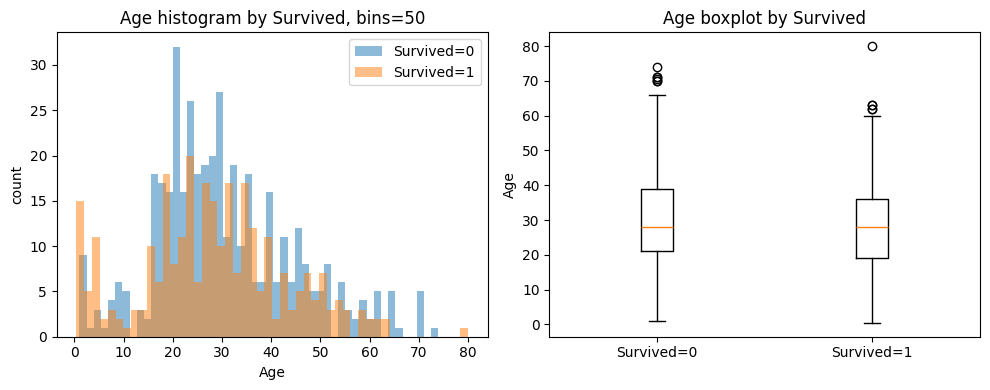


=== Fare ===
n(y=0)=549 | n(y=1)=342
y=0 stats:
 {'mean': 22.1179, 'median': 10.5, 'std': 31.3882, 'min': 0.0, 'q25': 7.8542, 'q75': 26.0, 'max': 263.0}
y=1 stats:
 {'mean': 48.3954, 'median': 26.0, 'std': 66.597, 'min': 0.0, 'q25': 12.475, 'q75': 57.0, 'max': 512.3292}
Mann–Whitney U: U=57806.5 | p-value=0.000000
Welch t-test: t=-6.839 | p-value=0.000000
Cohen's d (y=1 minus y=0): 0.547
Diff in medians (y=1 - y=0): 15.500 | 95% CI: [12.200, 17.050]
Diff in means   (y=1 - y=0): 26.278 | 95% CI: [18.953, 33.991]
Cohen's d CI: 95% CI: [0.429, 0.671]


C:\Users\User\AppData\Local\Temp\ipykernel_9864\273989076.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([a, b], labels=[f"{target}=0", f"{target}=1"], showfliers=True)


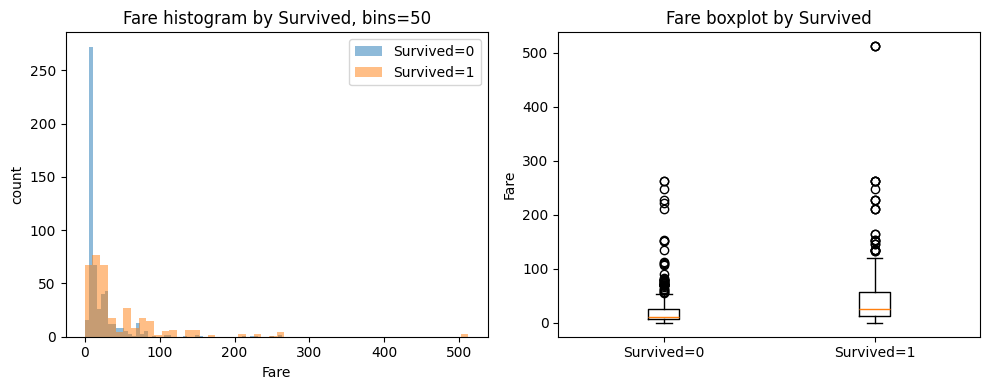


=== length_Name ===
n(y=0)=549 | n(y=1)=342
y=0 stats:
 {'mean': 24.5319, 'median': 24.0, 'std': 7.0686, 'min': 12.0, 'q25': 19.0, 'q75': 28.0, 'max': 57.0}
y=1 stats:
 {'mean': 30.8713, 'median': 28.5, 'std': 10.9414, 'min': 12.0, 'q25': 23.0, 'q75': 37.0, 'max': 82.0}
Mann–Whitney U: U=59830.5 | p-value=0.000000
Welch t-test: t=-9.546 | p-value=0.000000
Cohen's d (y=1 minus y=0): 0.724
Diff in medians (y=1 - y=0): 4.500 | 95% CI: [3.000, 6.000]
Diff in means   (y=1 - y=0): 6.339 | 95% CI: [5.060, 7.671]
Cohen's d CI: 95% CI: [0.585, 0.865]


C:\Users\User\AppData\Local\Temp\ipykernel_9864\273989076.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([a, b], labels=[f"{target}=0", f"{target}=1"], showfliers=True)


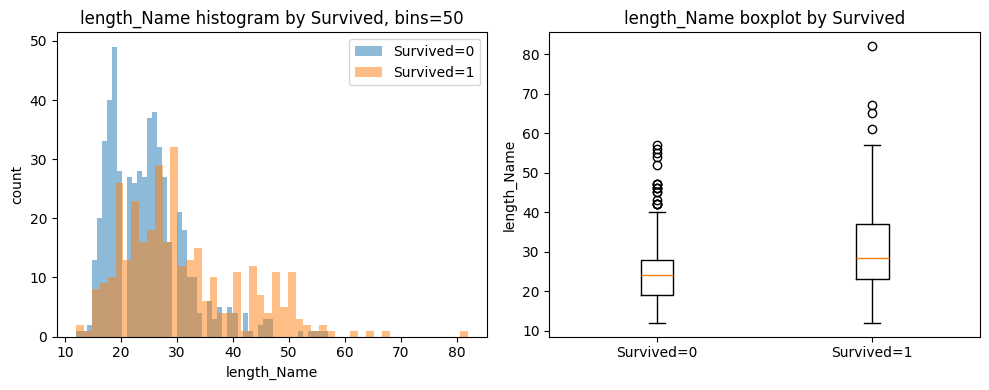

In [40]:
for col in num_cols.drop(['PassengerId', 'Survived']):
    num_vs_target(col)

what can be concluded:
1) The Fare is very strond predictor for the target. How?: based on the desc we can see that based on average and the median the survived people payed more for the ticket. what does test says?: both are close to 0, which state that the difference exist and for sure is not random. One thing to mention is when the plot is skewes and has outliers the Mann-Whitney test give more precise result, because the Welch t-test can misleas due to its focus on the mean.   Effect size is near to 0.55 which shows that the effect is medium
2) The Age is poor predictor in his current raw form, may need some feature engineering. Why?: Based on the desc, the mean and median are almost similar and from the plot it can be seen that they both overlaps. Test?: p value from Mann-Whitney is 0.16 which accept the H0(do not differ, which prove our point), but the Welch t test is 0.04 which is less than 0.05 and reject the H0. Here the problem is not in the data, but in the way these tests work, while the Mann-Whitney look at the wider picture of distribution, the Wltch t-test solely relies and focuses on the mean(it sees if the mean differ(H1) or do not differ(H0), which in our case mean differed). Visually from the plot we can see that the distrubtion for both target classes kinda normalish, that is why we can consider the both tests p value almost trustworthy. Here the Cohen'd is minus value which means that even if some tests gave the p value less than 0.05, practically the difference is weak.  To make this feature more useful we need to feature engineer it
3) The length_Name is also strong predictor for the target classes(which was suprising for me;). Bases on the desc we can see that there is clear difference in mean, median, and std, which is good because the data for each target classes distinguishable(The same can be seen from the boxplot). From the hist we see that the distribution is not normalish(right skewed) therefore the Welch t-test can mislead. but still both tests shows the p value to be close to 0, which means we reject the both H0(Wltch t-test: the mean differs, Mann-Whitney test: the distributon differs). And the Cohen's d is 0.724 which state that the effect is quite strond

Mostly I decide to feat engineer after working out the basemodel and seeing the weight it gives to the particular feature, but now since i believe that the Age in raw is not really usefull i am gonna cluster to other classes. for now i am gonna cluster with the simple median since it is not affected by the long tails

In [41]:
df['AgeGroup_median']=pd.cut(df['Age'].fillna(df['Age'].median()), bins=[0, 12, 20, 40, 60, np.inf], labels=['Child', 'Teenager', 'Adult', 'MiddleAged', 'Senior'])

In [42]:
cat_vs_target('AgeGroup_median')


=== AgeGroup_median ===
Survival rate:
 AgeGroup_median
Child         0.579710
MiddleAged    0.390625
Teenager      0.381818
Adult         0.364769
Senior        0.227273
Name: Survived, dtype: float64

Crosstab:
 Survived           0    1
AgeGroup_median          
Child             29   40
Teenager          68   42
Adult            357  205
MiddleAged        78   50
Senior            17    5

Survival rate + 95% CI (Wilson):
AgeGroup_median   n  survived_k  survival_rate  ci95_lo  ci95_hi
          Child  69          40       0.579710 0.462074 0.688939
     MiddleAged 128          50       0.390625 0.310470 0.477154
       Teenager 110          42       0.381818 0.296472 0.475140
          Adult 562         205       0.364769 0.326014 0.405359
         Senior  22           5       0.227273 0.101230 0.434400

Chi-square p-value: 0.006219 | dof=4
Expected values:
[[ 42.51515152  26.48484848]
 [ 67.77777778  42.22222222]
 [346.28282828 215.71717172]
 [ 78.86868687  49.13131313]
 [ 13.55

C:\Users\User\AppData\Local\Temp\ipykernel_9864\1215855341.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(col)[target].mean().sort_values(ascending=False)


In [43]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

In [44]:
print(cat_cols)
print(num_cols)

Index(['Pclass', 'Sex', 'Embarked', 'Title', 'Ticket_is_digit', 'FamilySize',
       'Cabin_symbol', 'Cabin_digit', 'FamilySize_cluster',
       'Title_transformed', 'AgeGroup_median'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Age', 'Fare', 'length_Name'], dtype='object')


In [45]:
def numeric_corr_matrices(num_cols, df=df,target="Survived")-> None:
    cols = list(num_cols)
    if target not in cols:
        cols = cols + [target]

    pearson = df[cols].corr(method="pearson")   # линейные связи
    spearman = df[cols].corr(method="spearman") # монотонные/нелинейные (по рангам)
    print("======" * 10)
    print("Pearson correlation matrix:")
    print(pearson)
    print("------" * 10)
    print("Spearman correlation matrix:")
    print(spearman)
    print("======" * 10)

In [46]:
numeric_corr_matrices(num_cols=num_cols.drop(['PassengerId']))

Pearson correlation matrix:
             Survived       Age      Fare  length_Name
Survived     1.000000 -0.077221  0.257307     0.332350
Age         -0.077221  1.000000  0.096067     0.034612
Fare         0.257307  0.096067  1.000000     0.155832
length_Name  0.332350  0.034612  0.155832     1.000000
------------------------------------------------------------
Spearman correlation matrix:
             Survived       Age      Fare  length_Name
Survived     1.000000 -0.052565  0.323736     0.305809
Age         -0.052565  1.000000  0.135051    -0.013112
Fare         0.323736  0.135051  1.000000     0.298848
length_Name  0.305809 -0.013112  0.298848     1.000000


what i see if the things that we have seen and predicted from the statistical tests. 

1) Fare is highly correlated with the Survived. gonna leave this feature but use the log1p to it when using the baseline such logisticregression. 

2) length_Name is highly correlated with the Survived. most likely due to the fact that most rich people has much longer names than the poor ones. but i see one problem which is this feature may partially duplicate the info from the feature such Title and Pclass. Which eventually when using the baseline such LogisticRegression may lead to problems such unpredictable weight for these features. for now i am gonna leave and check the score when using CV with baseline. And after thorough analysis we can see what i just said, the length_Name has a correlation with Fare: 0.32  (this value is not that big for now)

3) Age has bad correlation with the target that is due to its current raw form, that is why i priorly clustered it and will be seen the changes when we see the correlation of cat column with the target. the Age column gonna be deleted

4) other features correlates with each other within acceptable threshold(0-0.13), which means that these features gives different signals for determining the target

In [47]:
def cramers_v_from_crosstab(tab):
    chi2, p, dof, expected = stats.chi2_contingency(tab)
    n = tab.to_numpy().sum()
    r, k = tab.shape
    v = np.sqrt((chi2 / n) / (min(r - 1, k - 1) + 1e-12))
    return float(v), float(p)

def cat_to_target(df, cat_col, target="Survived"):
    tab = pd.crosstab(df[cat_col], df[target])
    rate = df.groupby(cat_col)[target].mean().sort_values(ascending=False)

    v, p = cramers_v_from_crosstab(tab)

    print(f"\n=== {cat_col} -> {target} ===")
    print("Survival rate by category:\n", rate)
    print("\nCrosstab:\n", tab)
    print(f"\nCramér’s V: {v:.3f} | chi-square p-value: {p:.6f}")
    print("======" * 10)
    
def cramers_v(x, y):
    tab = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(tab)
    n = tab.to_numpy().sum()
    r, k = tab.shape
    return float(np.sqrt((chi2 / n) / (min(r - 1, k - 1) + 1e-12)))

def cat_to_cat_matrix(df, cat_cols):
    M = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for c1 in cat_cols:
        for c2 in cat_cols:
            if c1 == c2:
                M.loc[c1, c2] = 1.0
            else:
                M.loc[c1, c2] = cramers_v(df[c1], df[c2])
    return M

here in the cat_to_target function we mostly look at the cramers_v. its value varies from 0 to 1.

    0.00–0.10 weak

    0.10–0.30 small to moderate

    0.30–0.50 moderate to strong

    >0.50 strong

the p value and cramers_v can be decribed in short as:

    p-value answers:“Is there evidence of any association at all?”

    Cramér’s V answers: “How strong is the association?”

In [48]:
for col in cat_cols:
    cat_to_target(df, col)


=== Pclass -> Survived ===
Survival rate by category:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Crosstab:
 Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Cramér’s V: 0.340 | chi-square p-value: 0.000000

=== Sex -> Survived ===
Survival rate by category:
 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Crosstab:
 Survived    0    1
Sex               
female     81  233
male      468  109

Cramér’s V: 0.541 | chi-square p-value: 0.000000

=== Embarked -> Survived ===
Survival rate by category:
 Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Crosstab:
 Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  217

Cramér’s V: 0.173 | chi-square p-value: 0.000002

=== Title -> Survived ===
Survival rate by category:
 Title
Lady            1.000000
Ms              1.000000
Sir             1.000000
Mme       

C:\Users\User\AppData\Local\Temp\ipykernel_9864\3769284446.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(cat_col)[target].mean().sort_values(ascending=False)
C:\Users\User\AppData\Local\Temp\ipykernel_9864\3769284446.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(cat_col)[target].mean().sort_values(ascending=False)
C:\Users\User\AppData\Local\Temp\ipykernel_9864\3769284446.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

The features that has a low effect or misleading: Title(misleading in raw because many classes with low occurence(Rare), that is why in prior i created new feature Title_transformed), Ticket_is_digit, FamilySize(The same staff happens as in the Title, and the FamilySize_cluster was created). i am not gonna remove them right away but gonna check with the cv looking for the result it gives with these feature and without.

The feature with low-medium effect: Embarked, Cabin_symbol(may mislead need to check with CV), AgeGroup_median(maybe becasue it was clustered to 5 classes may need less), and Cabin_digit(the result is okay but i want to make simple feature engineering to increase the V value )

What gonna do now is: see if the result change with the new class from the Age, and Cabin_digit

In [49]:
#different bins were attempted, and this one gave better results
df['AgeGroup_median']=pd.cut(df['Age'].fillna(df['Age'].median()), bins=[0, 8, 18, 50, np.inf], labels=['Child', 'Teen', 'Adult', 'Senior'])
cat_to_target(df, "AgeGroup_median")


=== AgeGroup_median -> Survived ===
Survival rate by category:
 AgeGroup_median
Child     0.666667
Teen      0.400000
Adult     0.363372
Senior    0.343750
Name: Survived, dtype: float64

Crosstab:
 Survived           0    1
AgeGroup_median          
Child             18   36
Teen              51   34
Adult            438  250
Senior            42   22

Cramér’s V: 0.150 | chi-square p-value: 0.000169


C:\Users\User\AppData\Local\Temp\ipykernel_9864\3769284446.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(cat_col)[target].mean().sort_values(ascending=False)


In [50]:
change_classes=['1_digit', '2_digit', '3_digit']
df['Cabin_digit_transformed'] = df['Cabin_digit'].replace(change_classes, 1, inplace=False)
df['Cabin_digit_transformed'].replace(['missing'], 0, inplace=True)
df['Cabin_digit_transformed']= df['Cabin_digit_transformed'].astype('category')

C:\Users\User\AppData\Local\Temp\ipykernel_9864\2007871729.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin_digit_transformed'].replace(['missing'], 0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9864\2007871729.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Cabin_

In [51]:
cat_to_target(df, "Cabin_digit_transformed")
#here i am gonna leave the feature as is, since it showed same correlation with the target as the previous version. will check with CV


=== Cabin_digit_transformed -> Survived ===
Survival rate by category:
 Cabin_digit_transformed
1    0.666667
0    0.299854
Name: Survived, dtype: float64

Crosstab:
 Survived                   0    1
Cabin_digit_transformed          
0                        481  206
1                         68  136

Cramér’s V: 0.314 | chi-square p-value: 0.000000


C:\Users\User\AppData\Local\Temp\ipykernel_9864\3769284446.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(cat_col)[target].mean().sort_values(ascending=False)


In [52]:
cat_cols= df.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['Pclass', 'Sex', 'Embarked', 'Title', 'Ticket_is_digit', 'FamilySize',
       'Cabin_symbol', 'Cabin_digit', 'FamilySize_cluster',
       'Title_transformed', 'AgeGroup_median', 'Cabin_digit_transformed'],
      dtype='object')

In [53]:
Vmat = cat_to_cat_matrix(df, cat_cols)
print(Vmat)

                           Pclass       Sex  Embarked     Title  \
Pclass                   1.000000  0.138013  0.263821  0.257116   
Sex                      0.138013  1.000000  0.122569  0.997890   
Embarked                 0.263821  0.122569  1.000000  0.197118   
Title                    0.257116  0.997890  0.197118  1.000000   
Ticket_is_digit          0.092078  0.029822  0.194996  0.158930   
FamilySize               0.223751  0.326685  0.164655  0.237311   
Cabin_symbol             0.605070  0.205545  0.204692  0.201731   
Cabin_digit              0.574945  0.143569  0.187435  0.179946   
FamilySize_cluster       0.190913  0.303647  0.135927  0.418147   
Title_transformed        0.207615  0.987168  0.151643  1.000000   
AgeGroup_median          0.203779  0.128388  0.058602  0.418077   
Cabin_digit_transformed  0.790878  0.137595  0.233190  0.247796   

                         Ticket_is_digit  FamilySize  Cabin_symbol  \
Pclass                          0.092078    0.223751      

here one stunning thing i saw is 
1) Title and Sex is very correleted

what i am gonna remove:

1)FamilySize(still have FamilySize_cluster which is more stable)

2)Title

3)Cabin_symbol and Cabin_digit(I already haev the Cabin_digit_transformed which is more stable due to its low amount of classes, and since it has correlation 1 with these 2 i decided to remove them)

4) Age 


what i want to check the importance with baseline:
    Embarked, length_Name,  Ticket_is_digit


In [54]:
df.rename(columns={'Cabin_digit_transformed': 'Has_Cabin_Number'}, inplace=True)

In [55]:
df.drop(columns=['Age', 'Title', 'Cabin_digit', 'Cabin_symbol', 'PassengerId', 'FamilySize'], inplace=True)

it is undisputable that Fare is very strong predictor, but since it has long tails and right skewed it may need some tranformation such coxbox or just simple log. but i am gonna do it later

what i think may decrease the metrics is relation of:
    1) Fare and Pclass(if the Fare is a lot it is more likely to be 1 class people and etc.)
    2) Fare and length_Name(people form 1st class more likely to have long name)

Why? Because some info may have duplicated and the weights will be randomly distributed when it comes to logisticregression



There are 2 most popular approaches for selecting the useful features:

    1) griddy selection. choose one by one while it shows improvements

    2) regulization l1(lasso)

then the approach for validating the selected features:
    Permutation importance

In [56]:
#griddy selection of features for logistic regression experiments
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

def run_logreg_experiments(
    df,
    target="Survived",
    experiments=None,
    cv_splits=5,
    scoring="roc_auc",
    random_state=42
):
    if experiments is None:
        raise ValueError("Pass experiments=dict(name -> list_of_features)")

    y = df[target]

    def make_pipe(features):
        X = df[features]

        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        cat_cols = [c for c in features if c not in num_cols]

        pre = ColumnTransformer(
            transformers=[
                ("num", SimpleImputer(strategy="median"), num_cols),
                ("cat", Pipeline(steps=[
                    ("impute", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore"))
                ]), cat_cols),
            ],
            remainder="drop"
        )

        model = LogisticRegression(max_iter=2000, solver="lbfgs")

        pipe = Pipeline(steps=[("pre", pre), ("model", model)])
        return pipe, X

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    results = []
    for name, features in experiments.items():
        pipe, X = make_pipe(features)
        scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring)
        results.append({
            "experiment": name,
            "n_features": len(features),
            "features": features,
            "cv_scores": scores.tolist(),        
            "mean": float(scores.mean()),
            "std": float(scores.std()),
            "min": float(scores.min()),
            "max": float(scores.max()),
        })

    out = pd.DataFrame(results)
    # compact print
    print(out[["experiment", "n_features", "mean", "std", "cv_scores"]].to_string(index=True))
    return out

base_cols = ["Sex", "AgeGroup_median", "Fare"]          
maybe_cols = ["Title_transformed"]                   
check_cols = ["Pclass", "Embarked", "Ticket_is_digit", "Has_Cabin_Number", "FamilySize_cluster", "length_Name"]


experiments = {
    # Core baselines
    "BASE: Sex + AgeGroup_median + Fare": base_cols,
    "BASE + Pclass": base_cols + ["Pclass"],
    "BASE + Pclass + Embarked": base_cols + ["Pclass", "Embarked"],
    "BASE + Pclass + FamilySize_cluster": base_cols + ["Pclass", "FamilySize_cluster"],
    "BASE + Pclass + Has_Cabin_Number": base_cols + ["Pclass", "Has_Cabin_Number"],
    "BASE + Pclass + Ticket_is_digit": base_cols + ["Pclass", "Ticket_is_digit"],

    # Add multiple strong ones together
    "BASE + Pclass + FamilySize_cluster + Embarked": base_cols + ["Pclass", "FamilySize_cluster", "Embarked"],
    "BASE + Pclass + FamilySize_cluster + Embarked + Has_Cabin_Number": base_cols + ["Pclass", "FamilySize_cluster", "Has_Cabin_Number", "Embarked"],
    "BASE + Pclass + FamilySize_cluster + Embarked + Ticket_is_digit": base_cols + ["Pclass", "FamilySize_cluster", "Embarked", "Ticket_is_digit"],
    "BASE + Pclass + FamilySize_cluster + Embarked + Has_Cabin_Number + Ticket_is_digit": base_cols + ["Pclass", "FamilySize_cluster", "Has_Cabin_Number", "Embarked", "Ticket_is_digit"],

    "BASE + Pclass + FamilySize_cluster + Embarked + Title_transformed": base_cols + ["Pclass", "FamilySize_cluster", "Embarked", 'Title_transformed'],
    "BASE + Pclass + FamilySize_cluster + Embarked + length_Name": base_cols + ["Pclass", "FamilySize_cluster", "Embarked", 'length_Name'],
    "BASE + Pclass + FamilySize_cluster + Embarked + Title_transformed + length_Name": base_cols + ["Pclass", "FamilySize_cluster", "Embarked", 'Title_transformed', 'length_Name'],

    
}

# Run
results = run_logreg_experiments(df, target="Survived", experiments=experiments, scoring="roc_auc", cv_splits=5)


                                                                            experiment  n_features      mean       std                                                                                             cv_scores
0                                                   BASE: Sex + AgeGroup_median + Fare           3  0.830839  0.024142  [0.8592885375494071, 0.8289438502673797, 0.8122994652406417, 0.7974598930481284, 0.8562026326286398]
1                                                                        BASE + Pclass           4  0.847354  0.023672  [0.8693017127799737, 0.8542112299465241, 0.8204545454545454, 0.8185828877005347, 0.8742188538758143]
2                                                             BASE + Pclass + Embarked           5  0.850235  0.020246  [0.8657444005270093, 0.8536096256684492, 0.8308823529411765, 0.8237967914438504, 0.8771439968089351]
3                                                   BASE + Pclass + FamilySize_cluster           5  0.862315  0.0196

the base with 3 features already give 0.83 mean accuracy. In the base was {Sex, AgeGroup_median, Fare}. Why i did not add Pclass or why i decided to choose them as the base? I think that really depends on the logic. fe for me the Pclass seem to have some info about the Fare, which may lead to duplicating the same info, which in our case undesired. But after adding we can see that it gave a 0.017 for the accuracy which is great.  I tried other 4 feat. and come up with 2 of them giving boost but 2 other did not. i tried to see them with with the best base separately and together for now since the feat may have work better with specific features but in our case it did not. then i tried other 2: Title_transformed and length_Name, which give as i thought the best score with the Title. because 1) length_Name logically did not hold any useful info because it was taken from the same feat Name as Title, but the info it gave was already similar to already existing feat such as Pclass or Fare, because rich people(1st class) tend to have long name and tend to pay more for Fare

In [57]:
results.iloc[results['mean'].idxmax()].cv_scores

[0.8957839262187088,
 0.8739973262032086,
 0.8572192513368986,
 0.8582219251336899,
 0.8990160882861321]

In [58]:
#trying to use the log for Fare
df['Fare_log']=np.log1p(df['Fare'])

In [59]:
experiments = {
    'The best but with the log_Fare': ["Sex", "AgeGroup_median", "Fare_log", "Pclass", "FamilySize_cluster", "Embarked", 'Title_transformed']
}
results = run_logreg_experiments(df, target="Survived", experiments=experiments, scoring="roc_auc", cv_splits=5)
results.iloc[results['mean'].idxmax()].cv_scores

                       experiment  n_features      mean       std                                                                                             cv_scores
0  The best but with the log_Fare           7  0.876729  0.014423  [0.8928853754940711, 0.8768048128342247, 0.8613636363636363, 0.8598262032085561, 0.8927669192926474]


[0.8928853754940711,
 0.8768048128342247,
 0.8613636363636363,
 0.8598262032085561,
 0.8927669192926474]

In [60]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

def l1_logreg_feature_selection(df, features, target="Survived", scoring="roc_auc", cv_splits=5, random_state=42):
    X = df[features]
    y = df[target]

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in features if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", Pipeline(steps=[
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first'))
            ]), cat_cols),
        ],
        remainder="drop"
    )

    model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000)

    pipe = Pipeline(steps=[("pre", pre), ("model", model)])

    # C:(smaller C -> stronger regularization -> fewer features)
    param_grid = {"model__C": [0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    gs = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    best_pipe = gs.best_estimator_
    best_C = gs.best_params_["model__C"]
    best_score = gs.best_score_

    ohe = best_pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([np.array(num_cols), cat_names])

    coef = best_pipe.named_steps["model"].coef_.ravel()
    selected_mask = np.abs(coef) > 1e-8

    selected = pd.DataFrame({
        "feature": feature_names[selected_mask],
        "coef": coef[selected_mask]
    }).sort_values("coef", key=np.abs, ascending=False)

    print(f"Best C = {best_C} | CV {scoring} = {best_score:.4f}")
    print(f"Selected features (non-zero): {selected.shape[0]} / {len(feature_names)}")

    return gs, selected

all_features = df.columns.drop('Survived', 'Fare').tolist()

gs, selected = l1_logreg_feature_selection(df, all_features, target="Survived", scoring="roc_auc")
display(selected.head(30))


Best C = 1 | CV roc_auc = 0.8761
Selected features (non-zero): 15 / 19


c:\Users\User\all_project\prokects_in_github\titanic_project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\User\all_project\prokects_in_github\titanic_project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


,feature,coef
7,FamilySize_cluster_LargeFamily,-3.046354
10,Title_transformed_Mr,-2.366359
11,Title_transformed_Rare,-1.714479
12,AgeGroup_median_Child,1.040717
14,Has_Cabin_Number_1,0.814886
3,Pclass_3,-0.700856
13,AgeGroup_median_Senior,-0.650469
8,FamilySize_cluster_MidSizeFamily,-0.498895
4,Sex_male,-0.495069
5,Embarked_S,-0.386084


it can be clearly seen that Fare is poor predictor while the Fare_log gives the whole 0.36. gonna remove the Fare, length_Name, Ticket_is_digit. before with the grid apporach we removed it, but here it gives 0.81 which gives hint that it is better to let it be.

In [61]:
final_features = ["Sex", "AgeGroup_median", "Fare_log", "Pclass", "FamilySize_cluster", "Embarked", 'Title_transformed', 'Has_Cabin_Number']

now i am gonna the importance now again with other approach: Permutation Importance

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

target = "Survived"

X = df[final_features]
y = df[target]

# 2) Train/valid split (simple and OK for explanation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Build the same preprocessing pipeline
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in final_features if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))  # optional drop for cleaner features
        ]), cat_cols),
    ],
    remainder="drop"
)

model = LogisticRegression(max_iter=5000, solver="lbfgs")

pipe = Pipeline(steps=[("pre", pre), ("model", model)])

# 4) Fit
pipe.fit(X_train, y_train)


r = permutation_importance(
    pipe,
    X_valid,
    y_valid,
    n_repeats=30,              # more repeats = more stable
    random_state=42,
    scoring="roc_auc"          
)

imp = pd.DataFrame({
    "feature": final_features,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std,
}).sort_values("importance_mean", ascending=False)

print(imp)


              feature  importance_mean  importance_std
6   Title_transformed         0.120334        0.028131
4  FamilySize_cluster         0.034376        0.010294
0                 Sex         0.022235        0.012809
3              Pclass         0.016146        0.005457
7    Has_Cabin_Number         0.008614        0.007683
1     AgeGroup_median         0.008373        0.006817
2            Fare_log         0.002123        0.007812
5            Embarked        -0.001702        0.005335


This approach shows how on average the metric(AUC) drops when the one of the feat. is moved(перемешена). 
how to understand it?:
0.03 means AUC on average drops by 0.03 -> feat is important
≈0 means almost do not affect
<0 more likely to be the noise

here from the result it may seem that Fare_log is not important but indeed this is not true. what it really means is the other features already give the same info. Here every feat except Fare_log and Embarked can be removed but i am gonna leave the Fare_log because subjectively it is still on of the important signals for deciding the target. but the Embarked gonna be removed

In [63]:
final_features.remove("Embarked")  

In [64]:
experiments = {
    'The final feat': final_features
}
results = run_logreg_experiments(df, target="Survived", experiments=experiments, scoring="roc_auc", cv_splits=5)
results.iloc[results['mean'].idxmax()].cv_scores

       experiment  n_features     mean       std                                                                                             cv_scores
0  The final feat           7  0.87438  0.017755  [0.8987483530961791, 0.8735294117647059, 0.8464572192513369, 0.8667780748663102, 0.8863847892567478]


[0.8987483530961791,
 0.8735294117647059,
 0.8464572192513369,
 0.8667780748663102,
 0.8863847892567478]

here the metric is a little low than was before but still is good because we do not want our model to overlearn

In [66]:
meta = {
    "target": "Survived",
    "final_features": final_features,
    "metric": "roc_auc",
    "random_state": 42
}

In [ ]:
import json


with open(ARTIFACTS_PATH/"features.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)